<a href="https://colab.research.google.com/github/SamuelBM21/IC/blob/main/HorsesOrHumansTransferResNeT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch                        #PyTorch
import torch.nn as nn               #Camadas da Rede neural
import torch.optim as optim         #Otimizadores
import torchvision                  #Datasets
import numpy as np
import random
from torchvision import transforms,datasets, models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt     #Visualização

In [ ]:
batch_size = 32
learning_rate = 0.0001
epochs = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Mesma normalização
])


train_data = datasets.ImageFolder('/content/drive/MyDrive/DataSets/horsehuman_train', transform=train_transforms)
test_data = datasets.ImageFolder('/content/drive/MyDrive/DataSets/horsehuman_test', transform=test_transforms)


val_ratio = 0.2
val_size = int(len(train_data) * val_ratio)
train_size = len(train_data) - val_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

# Substituir a última camada FC
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)

# A nova camada será treinada
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {acc:.2f}%")

        # Validação
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_acc = 100 * val_correct / val_total
        print(f"Val Accuracy: {val_acc:.2f}%")

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=epochs)


Epoch 1, Train Loss: 12.9912, Accuracy: 74.35%
Val Accuracy: 80.77%
Epoch 2, Train Loss: 10.4667, Accuracy: 76.80%
Val Accuracy: 80.00%
Epoch 3, Train Loss: 9.4202, Accuracy: 76.96%
Val Accuracy: 80.00%
Epoch 4, Train Loss: 8.4066, Accuracy: 78.65%
Val Accuracy: 85.38%
Epoch 5, Train Loss: 7.3864, Accuracy: 85.25%
Val Accuracy: 91.54%
Epoch 6, Train Loss: 6.7434, Accuracy: 89.71%
Val Accuracy: 96.92%
Epoch 7, Train Loss: 6.1223, Accuracy: 94.47%
Val Accuracy: 96.15%
Epoch 8, Train Loss: 5.4854, Accuracy: 96.01%
Val Accuracy: 96.15%
Epoch 9, Train Loss: 5.6087, Accuracy: 96.16%
Val Accuracy: 98.46%
Epoch 10, Train Loss: 4.6793, Accuracy: 97.85%
Val Accuracy: 98.46%


In [ ]:
#IMAGENS DE TESTE
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Acurácia no teste: {100 * correct / total:.2f}%")

test_model(model,test_loader)

Acurácia no teste: 100.00%


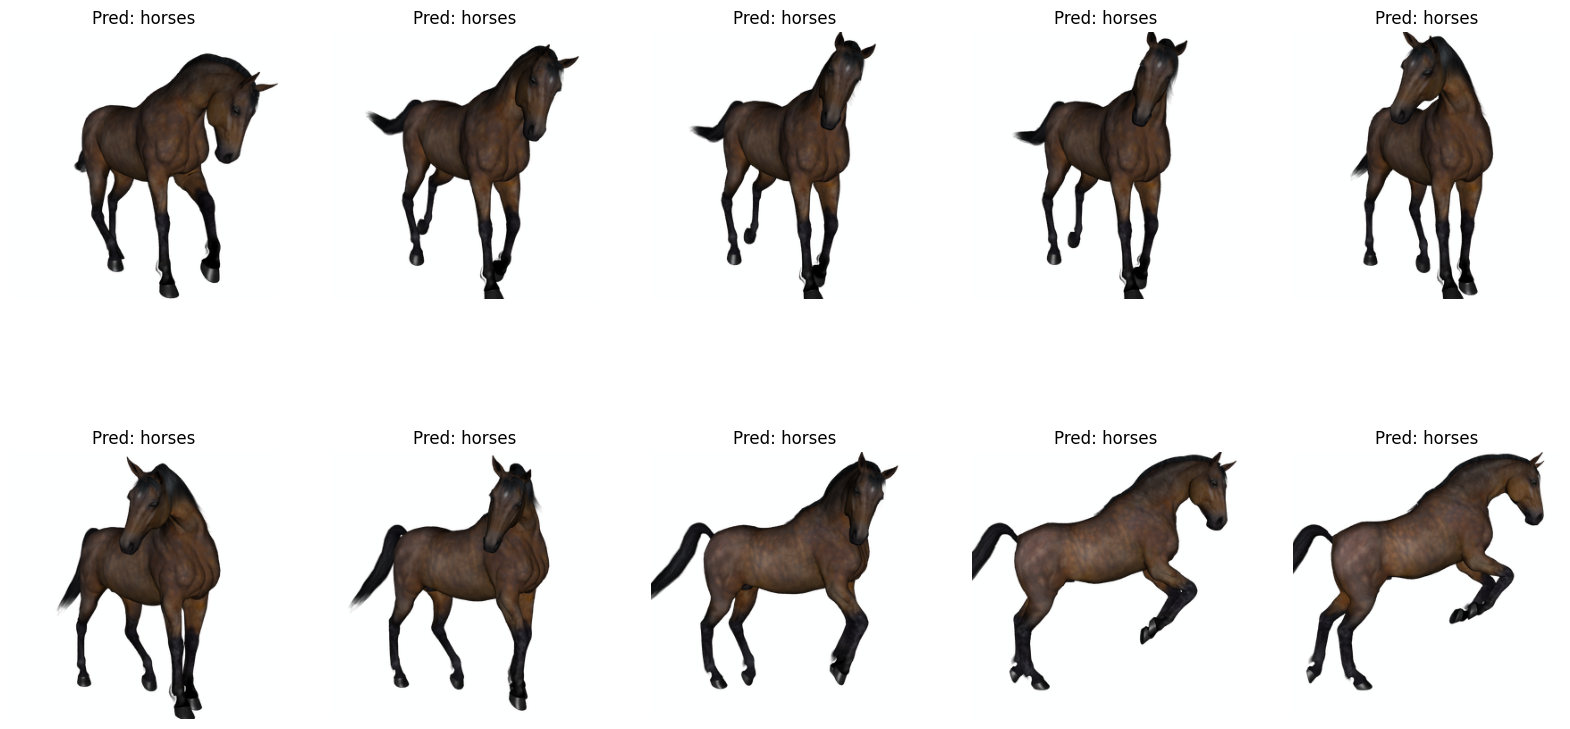

In [ ]:
def visualize_predictions(model, dataloader, class_names, num_images=6):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown == num_images:
                    plt.show()
                    return

                image = inputs[i].cpu().numpy().transpose((1, 2, 0))
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
                image = np.clip(image, 0, 1)

                plt.subplot(2, 5, images_shown + 1)
                plt.imshow(image)
                plt.title(f'Pred: {class_names[preds[i]]}')
                plt.axis('off')
                images_shown += 1

visualize_predictions(model, test_loader, train_data.classes, num_images=10)